## Preparation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Chargement et préparation des données
customers = pd.read_excel('../../customers_data_extended.xlsx')
sales = pd.read_excel('../../sales_data_extended.xlsx')

# Calcul de la CLV de base (hypothèse: marge de 20%, durée de vie moyenne 2 ans)
sales_agg = sales.groupby('Customer_ID').agg(
    total_spent=('Sale_Price', 'sum'),
    purchase_count=('Sale_ID', 'count'),
    avg_purchase_value=('Sale_Price', 'mean'),
    last_purchase_date=('Date', 'max'),
    first_purchase_date=('Date', 'min')
).reset_index()

df = pd.merge(customers, sales_agg, on='Customer_ID', how='left')

# Calcul des indicateurs temporels
current_date = pd.to_datetime('today')
df['customer_age_days'] = (current_date - df['Join_Date']).dt.days
df['purchase_period_days'] = (df['last_purchase_date'] - df['first_purchase_date']).dt.days
df['recency_days'] = (current_date - df['last_purchase_date']).dt.days

# Calcul de la CLV (simplifié)
df['CLV'] = (df['total_spent'] * 0.2 * (730 / df['customer_age_days'])).fillna(0)

# Transformation logarithmique pour normaliser
df['log_CLV'] = np.log1p(df['CLV'])

# Feature engineering additionnel
df['purchase_frequency'] = df['purchase_count'] / (df['customer_age_days'] / 30)  # achats par mois
df['monetary_value'] = df['total_spent'] / df['purchase_count']
df['activity_ratio'] = df['purchase_period_days'] / df['customer_age_days']

# Gestion des valeurs manquantes
df['monetary_value'] = df['monetary_value'].fillna(0)
df['activity_ratio'] = df['activity_ratio'].fillna(0)

# Variables catégorielles
df = pd.get_dummies(df, columns=['Gender', 'Location', 'Preferred_Channel'], drop_first=True)

# Sélection des features
features = [
    'Age', 'Income', 'Email_Open_Rate', 'customer_age_days',
    'purchase_count', 'avg_purchase_value', 'recency_days',
    'purchase_frequency', 'monetary_value', 'activity_ratio',
    'Gender_Male', 'Preferred_Channel_Online'
]

X = df[features]
y = df['log_CLV']  # Cible transformée

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Construction de modèle de prédiction

In [2]:
# Préprocesseur
numeric_features = [f for f in features if f not in ['Gender_Male', 'Preferred_Channel_Online']]
categorical_features = ['Gender_Male', 'Preferred_Channel_Online']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

# Modèles à comparer
models = {
    "Random Forest": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
    ]),
    "XGBoost": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(random_state=42, objective='reg:squarederror'))
    ]),
    "Linear Regression": Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
}

### Entrainement et Evaluation

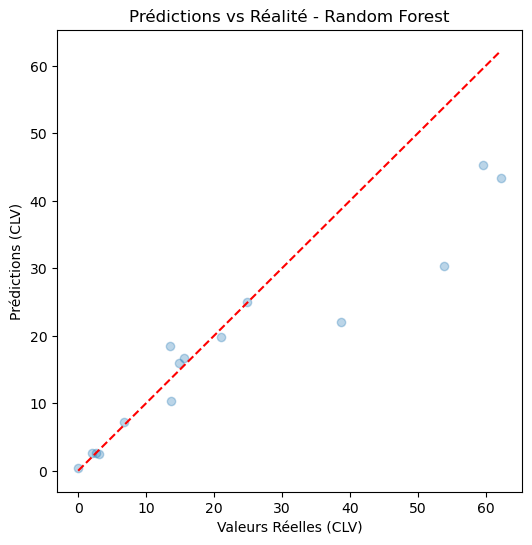

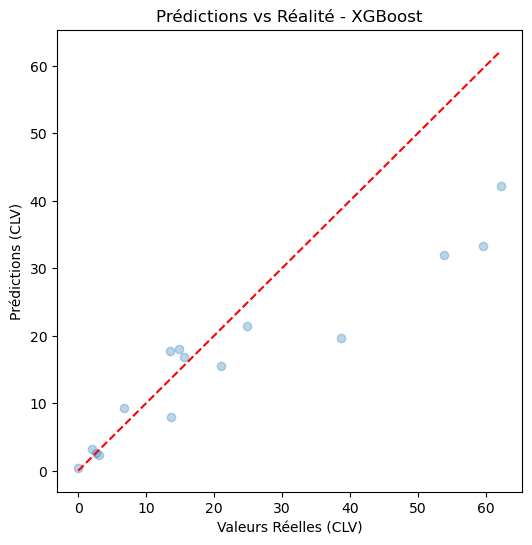

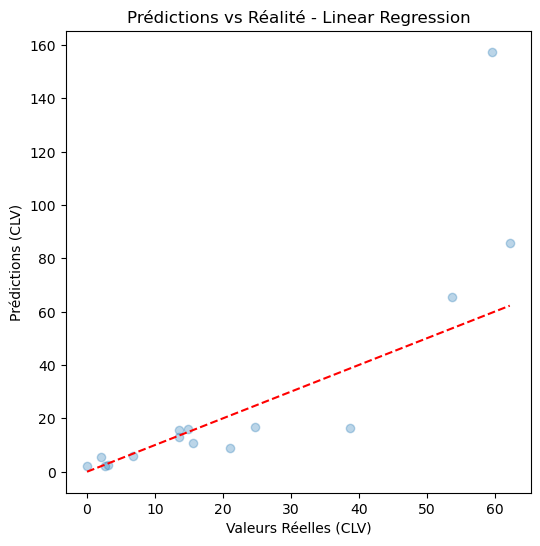

,RMSE,MAE,R2,MAPE
Model,,,,
Random Forest,9.759,5.812,0.777,inf
XGBoost,11.646,7.661,0.682,inf
Linear Regression,27.099,12.787,-0.719,inf


In [ ]:
results = []
for name, model in models.items():
    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédiction
    y_pred = model.predict(X_test)
    
    # Conversion des prédictions (log -> valeur réelle)
    y_pred_exp = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)
    
    # Métriques
    metrics = {
        'Model': name,
        'RMSE': np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)),
        'MAE': mean_absolute_error(y_test_exp, y_pred_exp),
        'R2': r2_score(y_test_exp, y_pred_exp),
        'MAPE': np.mean(np.abs((y_test_exp - y_pred_exp) / y_test_exp)) * 100
    }
    results.append(metrics)
    
    # Visualisation des prédictions vs réalité
    plt.figure(figsize=(6, 6))
    plt.scatter(y_test_exp, y_pred_exp, alpha=0.3)
    plt.plot([y_test_exp.min(), y_test_exp.max()], 
             [y_test_exp.min(), y_test_exp.max()], 'r--')
    plt.xlabel('Valeurs Réelles (CLV)')
    plt.ylabel('Prédictions (CLV)')
    plt.title(f'Prédictions vs Réalité - {name}')
    plt.savefig(f"M6/clv/predictions_vs_reality_{name}.png")
    plt.show()

# Résultats comparatifs
results_df = pd.DataFrame(results).set_index('Model')
display(results_df.round(3))

### Analyse des features importantes

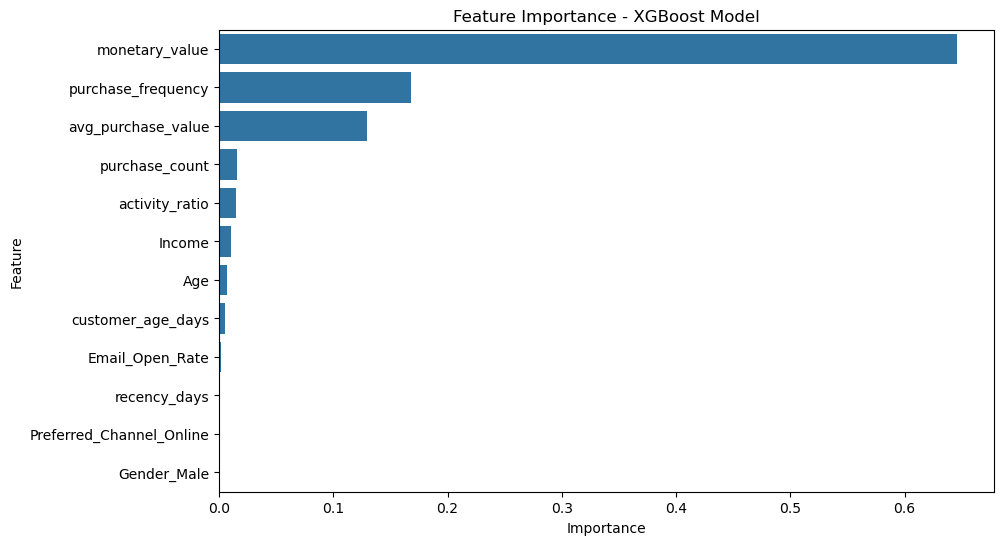

In [ ]:
# Extraire le meilleur modèle (XGBoost dans notre cas)
best_model = models['XGBoost']

# Feature importance
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    importances = best_model.named_steps['regressor'].feature_importances_
    feature_names = numeric_features + categorical_features
    
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance - XGBoost Model')
    plt.savefig("M6/clv/feature_importance_xgboost.png")
    plt.show()

### Segmentation des clients par CLV prédite

In [5]:
# Application du modèle à l'ensemble des données
df['predicted_log_CLV'] = best_model.predict(df[features])
df['predicted_CLV'] = np.expm1(df['predicted_log_CLV'])

# Segmentation en quintiles
df['CLV_segment'] = pd.qcut(df['predicted_CLV'], q=5, labels=[
    'Très Faible', 'Faible', 'Moyenne', 'Élevée', 'Très Élevée'
])

# Analyse des segments
segment_analysis = df.groupby('CLV_segment').agg({
    'Customer_ID': 'count',
    'predicted_CLV': ['mean', 'median'],
    'Age': 'mean',
    'Income': 'mean',
    'purchase_count': 'mean',
    'recency_days': 'mean'
})

print("Analyse des segments CLV:")
display(segment_analysis.round(2))

Analyse des segments CLV:


C:\Users\rasam\AppData\Local\Temp\ipykernel_2688\3232298027.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = df.groupby('CLV_segment').agg({


Customer_ID predicted_CLV               Age    Income  \
                  count          mean     median   mean      mean   
CLV_segment                                                         
Très Faible          10      1.240000   1.220000  43.20  79420.20   
Faible               10      5.890000   5.700000  36.20  88153.40   
Moyenne               9     15.660000  16.760000  40.78  90176.67   
Élevée               10     22.900000  21.030001  38.50  74441.30   
Très Élevée          10     67.419998  47.240002  39.10  76881.90   

            purchase_count recency_days  
                      mean         mean  
CLV_segment                              
Très Faible            1.0       832.62  
Faible                 1.2       884.10  
Moyenne                2.0       815.67  
Élevée                 2.3       819.10  
Très Élevée            3.9       797.80

### Visualisation

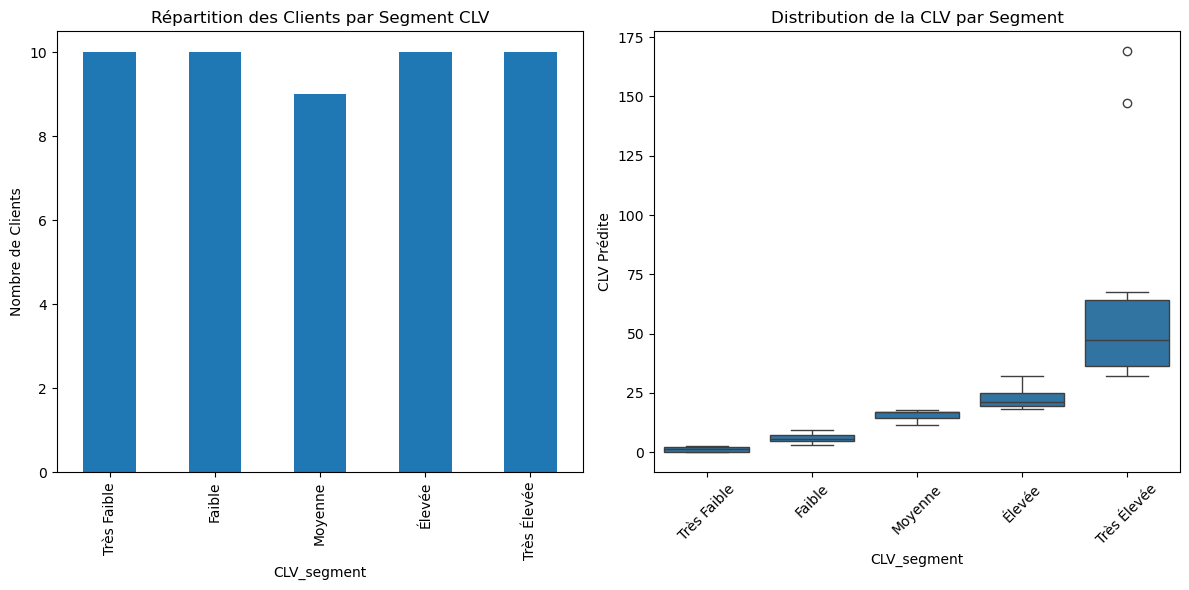

In [ ]:
plt.figure(figsize=(12, 6))

# Distribution des segments
plt.subplot(1, 2, 1)
df['CLV_segment'].value_counts().sort_index().plot(kind='bar')
plt.title('Répartition des Clients par Segment CLV')
plt.ylabel('Nombre de Clients')

# Valeur CLV par segment
plt.subplot(1, 2, 2)
sns.boxplot(x='CLV_segment', y='predicted_CLV', data=df)
plt.title('Distribution de la CLV par Segment')
plt.ylabel('CLV Prédite')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig("M6/clv/clv_segments_analysis.png")
plt.show()

### Export des résultats et recommandations

In [ ]:
# Préparation du fichier final
output_cols = [
    'Customer_ID', 'Name', 'Age', 'Income', 'predicted_CLV', 
    'CLV_segment', 'purchase_count', 'recency_days'
]
output = df[output_cols].sort_values('predicted_CLV', ascending=False)

# Export en CSV
output.to_csv('M6/clv/customer_clv_predictions.csv', index=False)

print("\nRésultats exportés avec succès. Statistiques finales:")
print(f"- CLV moyenne prédite: {output['predicted_CLV'].mean():.2f}")
print(f"- Nombre total de clients analysés: {len(output)}")
print(f"- Répartition des segments:\n{output['CLV_segment'].value_counts()}")

# Recommandations par segment CLV
print("Recommandations par Segment CLV:")

# Segment Très Élevé
print("\n1. Clients Très Élevée (Top 20%):")
print("- Programmes VIP avec avantages exclusifs")
print("- Services personnalisés et dédiés")
print("- Accès anticipé aux nouveaux produits")
print("- Invitations à des événements spéciaux")

# Segment Élevé
print("\n2. Clients Élevée (20-40%):")
print("- Programmes de fidélisation premium")
print("- Offres cross-sell sur mesure")
print("- Contenu exclusif et éducatif")
print("- Reconnaissance de leur valeur (badges, récompenses)")

# Segment Moyen
print("\n3. Clients Moyenne (40-60%):")
print("- Programmes de parrainage incitatifs")
print("- Bundles de produits complémentaires")
print("- Campagnes de réactivation ciblées")
print("- Enquêtes pour comprendre leurs besoins")

# Segment Faible
print("\n4. Clients Faible (60-80%):")
print("- Offres de bienvenue ou de retour")
print("- Contenu éducatif sur la valeur des produits")
print("- Tests de différents canaux de communication")
print("- Programmes d'engagement basiques")

# Segment Très Faible
print("\n5. Clients Très Faible (Bottom 20%):")
print("- Analyse coût/bénéfice de la relation client")
print("- Campagnes bas coût pour tester le potentiel")
print("- Optimisation des canaux à faible coût")
print("- Segmentation supplémentaire pour trouver des niches")


Résultats exportés avec succès. Statistiques finales:
- CLV moyenne prédite: 22.76
- Nombre total de clients analysés: 49
- Répartition des segments:
CLV_segment
Très Faible    10
Faible         10
Élevée         10
Très Élevée    10
Moyenne         9
Name: count, dtype: int64
Recommandations par Segment CLV:

1. Clients Très Élevée (Top 20%):
- Programmes VIP avec avantages exclusifs
- Services personnalisés et dédiés
- Accès anticipé aux nouveaux produits
- Invitations à des événements spéciaux

2. Clients Élevée (20-40%):
- Programmes de fidélisation premium
- Offres cross-sell sur mesure
- Contenu exclusif et éducatif
- Reconnaissance de leur valeur (badges, récompenses)

3. Clients Moyenne (40-60%):
- Programmes de parrainage incitatifs
- Bundles de produits complémentaires
- Campagnes de réactivation ciblées
- Enquêtes pour comprendre leurs besoins

4. Clients Faible (60-80%):
- Offres de bienvenue ou de retour
- Contenu éducatif sur la valeur des produits
- Tests de différents 